In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision 
from torchvision import transforms as T
from torchvision.datasets import CIFAR10, SVHN
import torch.nn.functional as F
from torch import optim

import os
import sys
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn import metrics
import wandb

from sklearn import metrics
#from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#from siamese_dataloader import CIFAR10_TrainPair, CIFAR10_ValPair #, CIFAR10_TestPair
from baseline_resnet import BasicBlock, Baseline_ResNet
from useful_fc import show_dist, show_auroc

### Prepare dataset

In [18]:
# load cifar10 dataset
transform = T.Compose([T.ToTensor(),
                       T.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),])
# CIFAR10 
torch.manual_seed(2021)
cifar10_dataset = CIFAR10(root="./data", train=True, transform=transform, download = False)  
cifar10_dataset_train, cifar10_dataset_val = torch.utils.data.random_split(cifar10_dataset, [40000, 10000])
cifar10_dataset_test = CIFAR10(root="./data", train=False, transform=transform, download =False)
# SVHN
svhn_dataset = SVHN(root="./data", split = 'train', transform=transform, download = False) 
# TinyImageNet
tinyimagenet_dataset = torchvision.datasets.ImageFolder("./data/Imagenet_resize", transform=transform)
# LSUN
lsun_dataset = torchvision.datasets.ImageFolder("./data/LSUN_resize", transform=transform)

In [19]:
# only load class 0-5 for training and validation
seen_classes = list(range(6)) #[4,5,6,7,8,9] #list(range(6))
train_seen_idx = [idx for idx, item in enumerate(cifar10_dataset_train) if item[1] in seen_classes]
val_seen_idx = [idx for idx, item in enumerate(cifar10_dataset_val) if item[1] in seen_classes]
cifar10_train_seen = Subset(cifar10_dataset_train, train_seen_idx)
cifar10_val_seen = Subset(cifar10_dataset_val, val_seen_idx)

In [20]:
train_dataloader = DataLoader(
            cifar10_train_seen,
            shuffle = True,
            batch_size=256,
            num_workers=0,
            drop_last=True,
            pin_memory=True,
        )
val_dataloader = DataLoader(
            cifar10_val_seen,
            shuffle = True,
            batch_size=256,
            num_workers=0,
            drop_last=True,
            pin_memory=True,
        )

In [5]:
wandb.login()

wandb: Currently logged in as: zoey7407 (use `wandb login --relogin` to force relogin)


True

In [17]:
model = Baseline_ResNet(BasicBlock, [2,2,2,2], num_classes = 6).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001, weight_decay=0.0001)

tr_batch = next(iter(train_dataloader))

In [21]:
def train():
    wandb.finish() 
    
    wandb.init(name='baseline-pretrain-best', # rotation', 
               project='Baseline-pretrain',
               config={"model": 'resnet18',
                       "resnet_layers": [2,2,2,2],
                       "num_classes": 6,
                       "learning_rate": 5e-4,
                       "weight_decay": 5e-4,
                       "max_epoch": 200,
                       "min_epoch": 0,  
                       "early_stop_patience": 20,
                       "seed": 2021})

    model = Baseline_ResNet(BasicBlock, wandb.config.resnet_layers, wandb.config.num_classes).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
    
    early_stop_counter = 0
    early_stop = False
    best_val_acc = 0

    torch.manual_seed(wandb.config.seed)

    for epoch in range(0,wandb.config.max_epoch):
        #train
        model.train()
        train_loss = 0
        train_correct = 0.0
        train_total = 0.0
        for i, tr_batch in enumerate(train_dataloader,0):
            tr_img, tr_label = tr_batch
            tr_img, tr_label = tr_img.cuda(), tr_label.cuda() 
            #tr_label = tr_label - 4  #target transform for class rotation
            optimizer.zero_grad()
            _, tr_logits = model(tr_img)
            tr_batch_loss = criterion(tr_logits,tr_label)
            tr_batch_loss.backward()
            optimizer.step()
            train_loss += tr_batch_loss.item()  
            tr_pred = tr_logits.max(dim=1)[1]
            train_total += tr_label.size(0)
            train_correct += (tr_pred == tr_label).sum()

        train_loss = train_loss/len(train_dataloader)   # mean epoch loss
        train_acc = train_correct/train_total   #epoch accuracy

        #validation
        model.eval()
        val_loss = 0
        val_correct = 0.0
        val_total = 0.0
        for j, val_batch in enumerate(val_dataloader,0):
            val_img, val_label = val_batch
            val_img, val_label = val_img.cuda(), val_label.cuda() 
            #val_label = val_label - 4 #target transform for class rotation
            _, val_logits = model(val_img)
            val_batch_loss = criterion(val_logits,val_label)
            val_loss += val_batch_loss.item()
            val_pred = val_logits.max(dim=1)[1]
            val_total += val_label.size(0)
            val_correct += (val_pred == val_label).sum()

        val_loss = val_loss/len(val_dataloader)
        val_acc = val_correct/val_total   # epoch accuracy

        print("Epoch {}\nTrain loss: {}, train accuracy: {}\nVal loss: {}, val accuracy: {}\n"
                    .format(epoch, train_loss, train_acc, val_loss, val_acc))

        wandb.log({
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Accuracy": train_acc,
            "Val Loss": val_loss, 
            "Val Accuracy": val_acc
            })
        
        #if epoch % 10 == 0:
        #    torch.save(model.state_dict(), "./stat_dict/baseline_pretrain_rotation_epoch_{}.pth".format(epoch))
            
       
        # early stop by validation accuracy
        if val_acc < best_val_acc:
            early_stop_counter += 1
            print(f'EarlyStopping counter: {early_stop_counter} out of {wandb.config.early_stop_patience}, best val accuracy: {best_val_acc}')
            if early_stop_counter >= wandb.config.early_stop_patience:
                early_stop = True
        else:
            best_val_acc = val_acc
            early_stop_counter = 0
            #torch.save(model.state_dict(), "./stat_dict/baseline_pretrain_best_class_rot.pth")

        if early_stop:
            print("Early stopping")
            break

    wandb.finish()

In [22]:
# seen classes = 0-5
train()

Epoch 0
Train loss: 1.0426026155604398, train accuracy: 0.5856032967567444
Val loss: 0.9191423337510292, val accuracy: 0.6436169743537903

Epoch 1
Train loss: 0.7338671942445684, train accuracy: 0.7191260457038879
Val loss: 0.811641311391871, val accuracy: 0.6923204660415649

Epoch 2
Train loss: 0.554492403160442, train accuracy: 0.7932820916175842
Val loss: 0.7229621740097695, val accuracy: 0.7312167286872864

Epoch 3
Train loss: 0.42043565221648804, train accuracy: 0.8456300497055054
Val loss: 0.8036740853431377, val accuracy: 0.717918872833252

EarlyStopping counter: 1 out of 20, best val accuracy: 0.7312167286872864
Epoch 4
Train loss: 0.3252057936739794, train accuracy: 0.8810160756111145
Val loss: 0.8113086477239081, val accuracy: 0.7325465083122253

Epoch 5
Train loss: 0.2399237316081868, train accuracy: 0.9126420617103577
Val loss: 0.9411609426457831, val accuracy: 0.7155917286872864

EarlyStopping counter: 1 out of 20, best val accuracy: 0.7325465083122253
Epoch 6
Train loss: 

Epoch 42
Train loss: 0.05422274592795713, train accuracy: 0.9814505577087402
Val loss: 0.9792211106482972, val accuracy: 0.7652925252914429

EarlyStopping counter: 8 out of 20, best val accuracy: 0.772606372833252
Epoch 43
Train loss: 0.055021018230600315, train accuracy: 0.9813669919967651
Val loss: 0.8978369527674736, val accuracy: 0.772606372833252

Epoch 44
Train loss: 0.049073499517844, train accuracy: 0.9832469820976257
Val loss: 0.9852598753381283, val accuracy: 0.7579786777496338

EarlyStopping counter: 1 out of 20, best val accuracy: 0.772606372833252
Epoch 45
Train loss: 0.04897720065157123, train accuracy: 0.9837483763694763
Val loss: 0.986520953634952, val accuracy: 0.7646276354789734

EarlyStopping counter: 2 out of 20, best val accuracy: 0.772606372833252
Epoch 46
Train loss: 0.0466989321225786, train accuracy: 0.9844585657119751
Val loss: 0.9455296004072149, val accuracy: 0.7719414830207825

EarlyStopping counter: 3 out of 20, best val accuracy: 0.772606372833252
Epoch 4

Epoch 82
Train loss: 0.03424655828365986, train accuracy: 0.9888870716094971
Val loss: 0.9605577385171931, val accuracy: 0.7807512879371643

EarlyStopping counter: 7 out of 20, best val accuracy: 0.7854055762290955
Epoch 83
Train loss: 0.030871102236520082, train accuracy: 0.9905581474304199
Val loss: 0.9598959544871716, val accuracy: 0.7789228558540344

EarlyStopping counter: 8 out of 20, best val accuracy: 0.7854055762290955
Epoch 84
Train loss: 0.03908879794230197, train accuracy: 0.9876754879951477
Val loss: 1.0465524361488667, val accuracy: 0.7623004913330078

EarlyStopping counter: 9 out of 20, best val accuracy: 0.7854055762290955
Epoch 85
Train loss: 0.036509903527567174, train accuracy: 0.9885528087615967
Val loss: 0.947173980956382, val accuracy: 0.7839095592498779

EarlyStopping counter: 10 out of 20, best val accuracy: 0.7854055762290955
Epoch 86
Train loss: 0.04099507317728896, train accuracy: 0.9866728186607361
Val loss: 0.9283394433082418, val accuracy: 0.780751287937164

Epoch 122
Train loss: 0.03265403241870357, train accuracy: 0.9900568127632141
Val loss: 0.9500175473537851, val accuracy: 0.7862367033958435

EarlyStopping counter: 18 out of 20, best val accuracy: 0.7918882966041565
Epoch 123
Train loss: 0.024170687344961146, train accuracy: 0.9929395318031311
Val loss: 1.0170622911859066, val accuracy: 0.786901593208313

EarlyStopping counter: 19 out of 20, best val accuracy: 0.7918882966041565
Epoch 124
Train loss: 0.03823839002263976, train accuracy: 0.9881768226623535
Val loss: 0.9244238239653567, val accuracy: 0.7878988981246948

EarlyStopping counter: 20 out of 20, best val accuracy: 0.7918882966041565
Early stopping


Epoch,124
Train Loss,0.03824
Train Accuracy,0.98818
Val Loss,0.92442
Val Accuracy,0.7879
_runtime,2178
_timestamp,1628063515
_step,124


Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▇▇▇███████████████████████████████████
Val Loss,▄▁▁▆▆▅▆█▅▅▇▅▆▇▆▄▇█▅▃▄▄▇▆▆▄▅▅▅▄▅▅▄▄▅▆▅▄▅▇
Val Accuracy,▁▅▆▅▅▆▆▆▆▆▆▇▆▇▆▇▇▆▇█▇▇▇▇█▇▇█▇▇▇▇█████▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [13]:
# class rotation, seen classes = 4-9
train()

Epoch 0
Train loss: 0.8240217995197378, train accuracy: 0.6905497908592224
Val loss: 0.7194454410801763, val accuracy: 0.74167799949646

Epoch 1
Train loss: 0.47868200244113085, train accuracy: 0.8285010457038879
Val loss: 0.5361707780672156, val accuracy: 0.8106318116188049

Epoch 2
Train loss: 0.33169298567236427, train accuracy: 0.8827707171440125
Val loss: 0.4905572255020556, val accuracy: 0.8291440606117249

Epoch 3
Train loss: 0.2455845577990945, train accuracy: 0.912892758846283
Val loss: 0.5218109183985254, val accuracy: 0.8265964984893799

EarlyStopping counter: 1 out of 20, best val accuracy: 0.8291440606117249
Epoch 4
Train loss: 0.17774953278787634, train accuracy: 0.9374164342880249
Val loss: 0.4968976657027784, val accuracy: 0.8425611853599548

Epoch 5
Train loss: 0.1511864839071896, train accuracy: 0.9476521015167236
Val loss: 0.5379797259102697, val accuracy: 0.839504063129425

EarlyStopping counter: 1 out of 20, best val accuracy: 0.8425611853599548
Epoch 6
Train loss:

Epoch 42
Train loss: 0.03924791054192552, train accuracy: 0.9878426194190979
Val loss: 0.4921164149823396, val accuracy: 0.871433436870575

Epoch 43
Train loss: 0.034309221147733895, train accuracy: 0.9895136952400208
Val loss: 0.495324999741886, val accuracy: 0.87109375

EarlyStopping counter: 1 out of 20, best val accuracy: 0.871433436870575
Epoch 44
Train loss: 0.035483281333547306, train accuracy: 0.9880514740943909
Val loss: 0.5771817020747972, val accuracy: 0.852921187877655

EarlyStopping counter: 2 out of 20, best val accuracy: 0.871433436870575
Epoch 45
Train loss: 0.04258050144286478, train accuracy: 0.9862132668495178
Val loss: 0.5508008942655895, val accuracy: 0.8603940606117249

EarlyStopping counter: 3 out of 20, best val accuracy: 0.871433436870575
Epoch 46
Train loss: 0.04248428565977928, train accuracy: 0.985711932182312
Val loss: 0.5299363868392032, val accuracy: 0.8653193116188049

EarlyStopping counter: 4 out of 20, best val accuracy: 0.871433436870575
Epoch 47
Trai

Epoch 84
Train loss: 0.0295814843213355, train accuracy: 0.9898061752319336
Val loss: 0.5577757520520169, val accuracy: 0.864130437374115

EarlyStopping counter: 2 out of 20, best val accuracy: 0.880264937877655
Epoch 85
Train loss: 0.023292539186805565, train accuracy: 0.9929813146591187
Val loss: 0.5176692708678867, val accuracy: 0.8722826242446899

EarlyStopping counter: 3 out of 20, best val accuracy: 0.880264937877655
Epoch 86
Train loss: 0.02528222337898046, train accuracy: 0.9920622110366821
Val loss: 0.5224949594425119, val accuracy: 0.87330162525177

EarlyStopping counter: 4 out of 20, best val accuracy: 0.880264937877655
Epoch 87
Train loss: 0.032848709477061894, train accuracy: 0.9892212748527527
Val loss: 0.572642466944197, val accuracy: 0.85767662525177

EarlyStopping counter: 5 out of 20, best val accuracy: 0.880264937877655
Epoch 88
Train loss: 0.02884544015807264, train accuracy: 0.9910594820976257
Val loss: 0.48850778263548145, val accuracy: 0.88060462474823

Epoch 89


Epoch 124
Train loss: 0.03018894813329798, train accuracy: 0.9900150299072266
Val loss: 0.5104282608498698, val accuracy: 0.8751698732376099

EarlyStopping counter: 6 out of 20, best val accuracy: 0.883661687374115
Epoch 125
Train loss: 0.022894581762406437, train accuracy: 0.9929813146591187
Val loss: 0.5589490643014079, val accuracy: 0.870754063129425

EarlyStopping counter: 7 out of 20, best val accuracy: 0.883661687374115
Epoch 126
Train loss: 0.020832900051276554, train accuracy: 0.9930648803710938
Val loss: 0.5018654601729434, val accuracy: 0.8804348111152649

EarlyStopping counter: 8 out of 20, best val accuracy: 0.883661687374115
Epoch 127
Train loss: 0.016979520951203485, train accuracy: 0.9948195219039917
Val loss: 0.5324454216853433, val accuracy: 0.8777174353599548

EarlyStopping counter: 9 out of 20, best val accuracy: 0.883661687374115
Epoch 128
Train loss: 0.018773053741620426, train accuracy: 0.9943599700927734
Val loss: 0.5532704190067623, val accuracy: 0.8699049353599

Epoch,152
Train Loss,0.0266
Train Accuracy,0.99194
Val Loss,0.51625
Val Accuracy,0.87602
_runtime,2608
_timestamp,1628060487
_step,152


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▇▇▇▇▇█▇███████████████████████████████
Val Loss,▃▂█▆▅▃▃▁▂▂▆▁▄▃▂▃▄▁▄▃▁▃▂▂▄▂▄▃▂▃▄▅▄▃▁▄▄▄▄▃
Val Accuracy,▁▃▁▄▄▆▅▇▆▆▅▇▆▆▇▆▆▇▇▇█▇▇▇▇█▆▇▇█▇▇▇██▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [7]:
sweep_config = {
    "project": 'Baseline - Sweep',
    "name" : "Baseline - Sweep",
    "method" : "random",
    "parameters" : {"learning_rate" : {"values":[1e-4, 5e-4,1e-3,5e-3,1e-2]}, # {"min": 1e-5,"max": 1e-3},
                    "weight_decay": {"values":[1e-4, 5e-4,1e-3,5e-3,1e-2]}}, #{"min": 1e-5, "max":1e-3}},
    "metric": {"name": "Val Accuracy", "goal": "maximize"},

  }

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train, count=10)

Create sweep with ID: p1546d6x
Sweep URL: https://wandb.ai/zoey7407/uncategorized/sweeps/p1546d6x


wandb: Agent Starting Run: arqx4hzk with config:
wandb: 	learning_rate: 0.001
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.124426570923432, train accuracy: 0.5527768731117249
Val loss: 1.1134697849100286, val accuracy: 0.55859375

Epoch 1
Train loss: 0.7636488028194593, train accuracy: 0.70363450050354
Val loss: 0.8636572144248269, val accuracy: 0.6759588122367859

Epoch 2
Train loss: 0.5831919280083283, train accuracy: 0.7765370607376099
Val loss: 0.8324114571918141, val accuracy: 0.6896306872367859

Epoch 3
Train loss: 0.4517825809509858, train accuracy: 0.83156418800354
Val loss: 0.8734288974241777, val accuracy: 0.7020596861839294

Epoch 4
Train loss: 0.3238803954875987, train accuracy: 0.883406937122345
Val loss: 0.8969002853740345, val accuracy: 0.7079190611839294

Epoch 5
Train loss: 0.24222951188035632, train accuracy: 0.9130434989929199
Val loss: 1.0473693771795793, val accuracy: 0.704723060131073

EarlyStopping counter: 1 out of 100, best val accuracy: 0.7079190611839294
Epoch 6
Train loss: 0.19696594062058823, train accuracy: 0.9284137487411499
Val loss: 0.8491280674934387,

Epoch 43
Train loss: 0.0323305186694083, train accuracy: 0.990106999874115
Val loss: 1.1311109391125767, val accuracy: 0.7297585606575012

EarlyStopping counter: 14 out of 100, best val accuracy: 0.7650923728942871
Epoch 44
Train loss: 0.046091143790956426, train accuracy: 0.9841627478599548
Val loss: 1.207019480791959, val accuracy: 0.7368608117103577

EarlyStopping counter: 15 out of 100, best val accuracy: 0.7650923728942871
Epoch 45
Train loss: 0.06199499940418679, train accuracy: 0.9795346856117249
Val loss: 1.0081163969906894, val accuracy: 0.7448508739471436

EarlyStopping counter: 16 out of 100, best val accuracy: 0.7650923728942871
Epoch 46
Train loss: 0.05336919054389, train accuracy: 0.98314368724823
Val loss: 1.0332759022712708, val accuracy: 0.7563920617103577

EarlyStopping counter: 17 out of 100, best val accuracy: 0.7650923728942871
Epoch 47
Train loss: 0.0404348091384315, train accuracy: 0.9877293109893799
Val loss: 0.9791339635848999, val accuracy: 0.7638494372367859


Epoch 82
Train loss: 0.02949864801991245, train accuracy: 0.9905316233634949
Val loss: 0.9287257411263206, val accuracy: 0.7787642478942871

Epoch 83
Train loss: 0.023669782013672848, train accuracy: 0.9922724366188049
Val loss: 1.032667490569028, val accuracy: 0.769176185131073

EarlyStopping counter: 1 out of 100, best val accuracy: 0.7787642478942871
Epoch 84
Train loss: 0.033671960700303316, train accuracy: 0.9889606237411499
Val loss: 1.217615615237843, val accuracy: 0.7510653734207153

EarlyStopping counter: 2 out of 100, best val accuracy: 0.7787642478942871
Epoch 85
Train loss: 0.043851952999830246, train accuracy: 0.98560631275177
Val loss: 0.9960321892391552, val accuracy: 0.773082435131073

EarlyStopping counter: 3 out of 100, best val accuracy: 0.7787642478942871
Epoch 86
Train loss: 0.0313606974263878, train accuracy: 0.9893427491188049
Val loss: 0.9898993372917175, val accuracy: 0.7682883739471436

EarlyStopping counter: 4 out of 100, best val accuracy: 0.7787642478942871

Epoch,99
Train Loss,0.02503
Train Accuracy,0.99223
Val Loss,0.94868
Val Accuracy,0.78161
_runtime,1140
_timestamp,1626662219
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▇▇▇███████████████████████████████████
Val Loss,█▁▆▆▇█▆▅█▄▅▃▇▄▅▄▅█▅█▆▄▄▅█▆▆▅▅█▅▅▄▆▅▅▆▆▅▄
Val Accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇█▇▇▇▇▇██▇▇█████▇█▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8rgomadf with config:
wandb: 	learning_rate: 0.001
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.1286327100318412, train accuracy: 0.5518003106117249
Val loss: 0.9948746020143683, val accuracy: 0.5960582494735718

Epoch 1
Train loss: 0.7675816520400669, train accuracy: 0.702275812625885
Val loss: 0.7854085618799383, val accuracy: 0.7001065611839294

Epoch 2
Train loss: 0.5730734959892605, train accuracy: 0.781632125377655
Val loss: 1.1105765429410068, val accuracy: 0.6326349377632141

EarlyStopping counter: 1 out of 100, best val accuracy: 0.7001065611839294
Epoch 3
Train loss: 0.43712517619132996, train accuracy: 0.83861243724823
Val loss: 0.8373112136667425, val accuracy: 0.7084517478942871

Epoch 4
Train loss: 0.2824409821111223, train accuracy: 0.8991168737411499
Val loss: 0.9948613426902078, val accuracy: 0.7056108117103577

EarlyStopping counter: 1 out of 100, best val accuracy: 0.7084517478942871
Epoch 5
Train loss: 0.2139320846485055, train accuracy: 0.923955500125885
Val loss: 1.2080143256620928, val accuracy: 0.6906960606575012

EarlyStopping counte

Epoch 42
Train loss: 0.028554797314269388, train accuracy: 0.990574061870575
Val loss: 1.2337479699741711, val accuracy: 0.7514204978942871

EarlyStopping counter: 9 out of 100, best val accuracy: 0.7615411877632141
Epoch 43
Train loss: 0.021231531094678718, train accuracy: 0.993036687374115
Val loss: 1.2121747732162476, val accuracy: 0.7562144994735718

EarlyStopping counter: 10 out of 100, best val accuracy: 0.7615411877632141
Epoch 44
Train loss: 0.023662109515103308, train accuracy: 0.9922724366188049
Val loss: 1.229828336022117, val accuracy: 0.7428977489471436

EarlyStopping counter: 11 out of 100, best val accuracy: 0.7615411877632141
Epoch 45
Train loss: 0.026174288324039917, train accuracy: 0.99146568775177
Val loss: 1.1538254781202837, val accuracy: 0.7599431872367859

EarlyStopping counter: 12 out of 100, best val accuracy: 0.7615411877632141
Epoch 46
Train loss: 0.02974560388120944, train accuracy: 0.9901919364929199
Val loss: 1.1389525912024758, val accuracy: 0.76047587394

Epoch 82
Train loss: 0.01883482619229218, train accuracy: 0.9939708113670349
Val loss: 1.2024907632307573, val accuracy: 0.7542613744735718

EarlyStopping counter: 6 out of 100, best val accuracy: 0.7721946239471436
Epoch 83
Train loss: 0.019250467176670612, train accuracy: 0.9934613108634949
Val loss: 1.1687654419378801, val accuracy: 0.7583451867103577

EarlyStopping counter: 7 out of 100, best val accuracy: 0.7721946239471436
Epoch 84
Train loss: 0.020684891021000625, train accuracy: 0.9929518103599548
Val loss: 1.1496854478662664, val accuracy: 0.7590554356575012

EarlyStopping counter: 8 out of 100, best val accuracy: 0.7721946239471436
Epoch 85
Train loss: 0.014075819524409979, train accuracy: 0.99562668800354
Val loss: 1.1740417155352505, val accuracy: 0.7592329978942871

EarlyStopping counter: 9 out of 100, best val accuracy: 0.7721946239471436
Epoch 86
Train loss: 0.015050582638334321, train accuracy: 0.9947775602340698
Val loss: 1.133487804369493, val accuracy: 0.762784123420

Epoch,99
Train Loss,0.01511
Train Accuracy,0.99554
Val Loss,1.22016
Val Accuracy,0.7603
_runtime,1113
_timestamp,1626663337
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▇▇████████████████████████████████████
Val Loss,▁▃▅▁▃▄▅▄▇▄▅█▅▄▅▄▆▅▄▄▇▄▄▄▅▇▃▇▃▄▄▄▅▄▄▄▅▅▃▅
Val Accuracy,▁▂▅▇▇▇▇▇▆▇▇▆▇█▇▇▇▇█▇▇▇█▇▇▇█▇████▇▇██▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uft82k3h with config:
wandb: 	learning_rate: 0.005
wandb: 	weight_decay: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.5336054563522339, train accuracy: 0.400263249874115
Val loss: 1.7047621120106091, val accuracy: 0.2638494372367859

Epoch 1
Train loss: 1.1608344264652417, train accuracy: 0.5325238108634949
Val loss: 1.627905780618841, val accuracy: 0.33256393671035767

Epoch 2
Train loss: 1.0537435360576795, train accuracy: 0.5796535611152649
Val loss: 1.6446069262244485, val accuracy: 0.29403409361839294

EarlyStopping counter: 1 out of 100, best val accuracy: 0.33256393671035767
Epoch 3
Train loss: 0.9986467478067979, train accuracy: 0.602921187877655
Val loss: 1.289296724579551, val accuracy: 0.4632457494735718

Epoch 4
Train loss: 0.9671535647433737, train accuracy: 0.62376868724823
Val loss: 1.321534351869063, val accuracy: 0.49520596861839294

Epoch 5
Train loss: 0.9326609930266505, train accuracy: 0.63841712474823
Val loss: 1.1497533429752698, val accuracy: 0.5369318127632141

Epoch 6
Train loss: 0.879877059356026, train accuracy: 0.663425624370575
Val loss: 1.27152603322

Epoch 42
Train loss: 0.43905520957449207, train accuracy: 0.8435377478599548
Val loss: 0.7205365733666853, val accuracy: 0.7395241856575012

EarlyStopping counter: 13 out of 100, best val accuracy: 0.7546164989471436
Epoch 43
Train loss: 0.42746281235114386, train accuracy: 0.84693443775177
Val loss: 0.7104508009823886, val accuracy: 0.7425426244735718

EarlyStopping counter: 14 out of 100, best val accuracy: 0.7546164989471436
Epoch 44
Train loss: 0.4515636323586754, train accuracy: 0.841414749622345
Val loss: 0.9622167511419817, val accuracy: 0.6786221861839294

EarlyStopping counter: 15 out of 100, best val accuracy: 0.7546164989471436
Epoch 45
Train loss: 0.43965226476607117, train accuracy: 0.8440472483634949
Val loss: 0.7219385721466758, val accuracy: 0.7313565611839294

EarlyStopping counter: 16 out of 100, best val accuracy: 0.7546164989471436
Epoch 46
Train loss: 0.44455435807290283, train accuracy: 0.8392918109893799
Val loss: 0.8115971847013994, val accuracy: 0.7320668101310

Epoch 82
Train loss: 0.3883584724820178, train accuracy: 0.8611158728599548
Val loss: 0.8294668685306202, val accuracy: 0.7107599377632141

EarlyStopping counter: 9 out of 100, best val accuracy: 0.7817826867103577
Epoch 83
Train loss: 0.39688196843085083, train accuracy: 0.8582286238670349
Val loss: 0.9490782997824929, val accuracy: 0.6906960606575012

EarlyStopping counter: 10 out of 100, best val accuracy: 0.7817826867103577
Epoch 84
Train loss: 0.37573087085848267, train accuracy: 0.86765456199646
Val loss: 0.9237686178900979, val accuracy: 0.7123579978942871

EarlyStopping counter: 11 out of 100, best val accuracy: 0.7817826867103577
Epoch 85
Train loss: 0.38834377410619153, train accuracy: 0.860478937625885
Val loss: 0.7772266702218489, val accuracy: 0.7357954978942871

EarlyStopping counter: 12 out of 100, best val accuracy: 0.7817826867103577
Epoch 86
Train loss: 0.37295642300792364, train accuracy: 0.8693104982376099
Val loss: 0.7885474454272877, val accuracy: 0.7265625

Early

Epoch,99
Train Loss,0.37427
Train Accuracy,0.86451
Val Loss,0.66585
Val Accuracy,0.77166
_runtime,1094
_timestamp,1626664436
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇█▇███████████████████████
Val Loss,██▄▅▄▃▁▂▃▂▃▃▃▃▃▃▂▂▂▃▂▄▃▃▄▃▂▄▄▁▄▂▁▃▂▂▃▂▁▁
Val Accuracy,▁▁▅▄▅▆█▇▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇█▆▆█▆██▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fb0h21wv with config:
wandb: 	learning_rate: 0.001
wandb: 	weight_decay: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.1316676036171291, train accuracy: 0.5491253733634949
Val loss: 1.2684911706230857, val accuracy: 0.4976917803287506

Epoch 1
Train loss: 0.801589732584746, train accuracy: 0.68873131275177
Val loss: 0.9097240242091092, val accuracy: 0.6590909361839294

Epoch 2
Train loss: 0.6700873115788335, train accuracy: 0.7452021241188049
Val loss: 0.9096032164313577, val accuracy: 0.6606889367103577

Epoch 3
Train loss: 0.585626777747403, train accuracy: 0.78074049949646
Val loss: 0.7900992686098273, val accuracy: 0.7034801244735718

Epoch 4
Train loss: 0.50122845755971, train accuracy: 0.81593918800354
Val loss: 0.9159281524744901, val accuracy: 0.6727628111839294

EarlyStopping counter: 1 out of 100, best val accuracy: 0.7034801244735718
Epoch 5
Train loss: 0.4684747418631678, train accuracy: 0.82961106300354
Val loss: 0.7982704531062733, val accuracy: 0.716441810131073

Epoch 6
Train loss: 0.4178748649099599, train accuracy: 0.8474439978599548
Val loss: 0.9126844514500011,

Epoch 42
Train loss: 0.12446741775973984, train accuracy: 0.9601732492446899
Val loss: 0.8934002627025951, val accuracy: 0.7448508739471436

EarlyStopping counter: 4 out of 100, best val accuracy: 0.7821378111839294
Epoch 43
Train loss: 0.10779875419709993, train accuracy: 0.966796875
Val loss: 0.861676503311504, val accuracy: 0.7737926244735718

EarlyStopping counter: 5 out of 100, best val accuracy: 0.7821378111839294
Epoch 44
Train loss: 0.12612699782070907, train accuracy: 0.9606403112411499
Val loss: 0.9340811588547446, val accuracy: 0.7645596861839294

EarlyStopping counter: 6 out of 100, best val accuracy: 0.7821378111839294
Epoch 45
Train loss: 0.1140822086321271, train accuracy: 0.9654806852340698
Val loss: 0.9214773665774952, val accuracy: 0.7388139367103577

EarlyStopping counter: 7 out of 100, best val accuracy: 0.7821378111839294
Epoch 46
Train loss: 0.11392727818178094, train accuracy: 0.9646739363670349
Val loss: 0.828876560384577, val accuracy: 0.7581676244735718

Early

Epoch 82
Train loss: 0.07683790782871454, train accuracy: 0.977156937122345
Val loss: 0.7481624754992399, val accuracy: 0.8018466234207153

Epoch 83
Train loss: 0.08767224410953729, train accuracy: 0.97312331199646
Val loss: 0.7862360585819591, val accuracy: 0.7885298728942871

EarlyStopping counter: 1 out of 100, best val accuracy: 0.8018466234207153
Epoch 84
Train loss: 0.08489939853872942, train accuracy: 0.97337806224823
Val loss: 0.8005243323066018, val accuracy: 0.7904829978942871

EarlyStopping counter: 2 out of 100, best val accuracy: 0.8018466234207153
Epoch 85
Train loss: 0.08380441205657047, train accuracy: 0.974609375
Val loss: 0.8755435889417474, val accuracy: 0.7629616856575012

EarlyStopping counter: 3 out of 100, best val accuracy: 0.8018466234207153
Epoch 86
Train loss: 0.09485506930429002, train accuracy: 0.971297562122345
Val loss: 0.7876618341966108, val accuracy: 0.7752130627632141

EarlyStopping counter: 4 out of 100, best val accuracy: 0.8018466234207153
Epoch 87

Epoch,99
Train Loss,0.08494
Train Accuracy,0.97452
Val Loss,0.76799
Val Accuracy,0.78746
_runtime,1094
_timestamp,1626665535
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▅▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
Val Loss,█▄▂▁▂▁▄▃▄▂▄▁▂▂▆▂▄▃▄▂▃▄▂▂▃▂▃▂▃▂▂▃▂▂▂▃▂▃▃▂
Val Accuracy,▁▅▆▇▇▇▆▆▆▇▆▇▇▇▆█▇▇▇██▇▇▇▇██████▇██▇▇████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hu1kthvj with config:
wandb: 	learning_rate: 0.005
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.5466502645741338, train accuracy: 0.39656931161880493
Val loss: 1.6372500332919033, val accuracy: 0.3201349675655365

Epoch 1
Train loss: 1.1963492424591728, train accuracy: 0.51320481300354
Val loss: 1.862748622894287, val accuracy: 0.29758524894714355

EarlyStopping counter: 1 out of 100, best val accuracy: 0.3201349675655365
Epoch 2
Train loss: 1.1482641904250435, train accuracy: 0.530613124370575
Val loss: 1.481311635537581, val accuracy: 0.40092331171035767

Epoch 3
Train loss: 1.109032338080199, train accuracy: 0.5515879988670349
Val loss: 1.6769770600579001, val accuracy: 0.3299005925655365

EarlyStopping counter: 1 out of 100, best val accuracy: 0.40092331171035767
Epoch 4
Train loss: 1.0999252264914305, train accuracy: 0.554814875125885
Val loss: 1.6919675848700784, val accuracy: 0.3100142180919647

EarlyStopping counter: 2 out of 100, best val accuracy: 0.40092331171035767
Epoch 5
Train loss: 1.112071129290954, train accuracy: 0.5548573732376099
Val loss

Epoch 42
Train loss: 0.5976943956769031, train accuracy: 0.78468918800354
Val loss: 1.1048054044896907, val accuracy: 0.6095525622367859

EarlyStopping counter: 4 out of 100, best val accuracy: 0.7192826867103577
Epoch 43
Train loss: 0.5932968012664629, train accuracy: 0.78490149974823
Val loss: 0.9463258656588468, val accuracy: 0.654296875

EarlyStopping counter: 5 out of 100, best val accuracy: 0.7192826867103577
Epoch 44
Train loss: 0.5904949514762216, train accuracy: 0.78566575050354
Val loss: 0.9237531802871011, val accuracy: 0.655894935131073

EarlyStopping counter: 6 out of 100, best val accuracy: 0.7192826867103577
Epoch 45
Train loss: 0.5897406223027603, train accuracy: 0.785283625125885
Val loss: 0.94715262001211, val accuracy: 0.6512784361839294

EarlyStopping counter: 7 out of 100, best val accuracy: 0.7192826867103577
Epoch 46
Train loss: 0.5982816893121471, train accuracy: 0.781886875629425
Val loss: 1.1160723837939175, val accuracy: 0.6173650622367859

EarlyStopping coun

Epoch 81
Train loss: 0.5500598763642104, train accuracy: 0.801163375377655
Val loss: 0.8606366081671282, val accuracy: 0.7038352489471436

EarlyStopping counter: 43 out of 100, best val accuracy: 0.7192826867103577
Epoch 82
Train loss: 0.5445545808128689, train accuracy: 0.804093062877655
Val loss: 0.9311123490333557, val accuracy: 0.657848060131073

EarlyStopping counter: 44 out of 100, best val accuracy: 0.7192826867103577
Epoch 83
Train loss: 0.5655688539795254, train accuracy: 0.794794499874115
Val loss: 0.9594196243719622, val accuracy: 0.6589133739471436

EarlyStopping counter: 45 out of 100, best val accuracy: 0.7192826867103577
Epoch 84
Train loss: 0.5410735749680063, train accuracy: 0.8067255616188049
Val loss: 0.9182582118294456, val accuracy: 0.6654829978942871

EarlyStopping counter: 46 out of 100, best val accuracy: 0.7192826867103577
Epoch 85
Train loss: 0.5449982816758363, train accuracy: 0.8047724366188049
Val loss: 0.9034577120434154, val accuracy: 0.6889204978942871



Epoch,99
Train Loss,0.53739
Train Accuracy,0.80868
Val Loss,0.76154
Val Accuracy,0.71893
_runtime,1102
_timestamp,1626666643
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██▇███████████████████████
Val Loss,▇▆█▇▅▄▃▅▅▂▂▂▂▄▅▁▂▂▂▃▁▄▅▄▆▄▅▁▂▄▅▃▂▃▂▂▄▆▃▁
Val Accuracy,▁▂▂▃▃▅▆▅▅█▇▇▇▆▅█▇▇▇▆█▆▅▆▅▆▆██▆▆▇█▇██▆▅▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: q6pqgpsh with config:
wandb: 	learning_rate: 0.005
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.5201054552327031, train accuracy: 0.400263249874115
Val loss: 1.3151575326919556, val accuracy: 0.45809659361839294

Epoch 1
Train loss: 1.0761758853559908, train accuracy: 0.5674253106117249
Val loss: 1.0452570048245517, val accuracy: 0.5871804356575012

Epoch 2
Train loss: 0.9369218129178752, train accuracy: 0.6317934989929199
Val loss: 0.9699100364338268, val accuracy: 0.6186079978942871

Epoch 3
Train loss: 0.83680299701898, train accuracy: 0.6719174981117249
Val loss: 0.8728259205818176, val accuracy: 0.6606889367103577

Epoch 4
Train loss: 0.732785808003467, train accuracy: 0.720066249370575
Val loss: 0.9425827915018256, val accuracy: 0.6468394994735718

EarlyStopping counter: 1 out of 100, best val accuracy: 0.6606889367103577
Epoch 5
Train loss: 0.6595356166362762, train accuracy: 0.7509341239929199
Val loss: 0.8000391667539423, val accuracy: 0.7049005627632141

Epoch 6
Train loss: 0.5773703106071638, train accuracy: 0.7864300608634949
Val loss: 0.90930887

Epoch 45
Train loss: 0.03946164823339685, train accuracy: 0.9861583113670349
Val loss: 1.0799704031510786, val accuracy: 0.765625

EarlyStopping counter: 9 out of 100, best val accuracy: 0.7865767478942871
Epoch 46
Train loss: 0.05902047151618678, train accuracy: 0.979110062122345
Val loss: 1.0603306185115466, val accuracy: 0.7764559984207153

EarlyStopping counter: 10 out of 100, best val accuracy: 0.7865767478942871
Epoch 47
Train loss: 0.07468783029395601, train accuracy: 0.9732082486152649
Val loss: 1.0474459745667197, val accuracy: 0.7727273106575012

EarlyStopping counter: 11 out of 100, best val accuracy: 0.7865767478942871
Epoch 48
Train loss: 0.07416013166632342, train accuracy: 0.97388756275177
Val loss: 0.9734024242921309, val accuracy: 0.779296875

EarlyStopping counter: 12 out of 100, best val accuracy: 0.7865767478942871
Epoch 49
Train loss: 0.05939369203279848, train accuracy: 0.979831874370575
Val loss: 0.9961967359889637, val accuracy: 0.7801846861839294

EarlyStopping

Epoch 85
Train loss: 0.046567678006122944, train accuracy: 0.98390793800354
Val loss: 1.0627344684167341, val accuracy: 0.775390625

EarlyStopping counter: 8 out of 100, best val accuracy: 0.796875
Epoch 86
Train loss: 0.053258650328802025, train accuracy: 0.9813604354858398
Val loss: 1.12769000638615, val accuracy: 0.7642045617103577

EarlyStopping counter: 9 out of 100, best val accuracy: 0.796875
Epoch 87
Train loss: 0.045094954214342266, train accuracy: 0.9845448732376099
Val loss: 1.077410015192899, val accuracy: 0.7794744372367859

EarlyStopping counter: 10 out of 100, best val accuracy: 0.796875
Epoch 88
Train loss: 0.05987623868429143, train accuracy: 0.97902512550354
Val loss: 1.0884771130301736, val accuracy: 0.771484375

EarlyStopping counter: 11 out of 100, best val accuracy: 0.796875
Epoch 89
Train loss: 0.05390027311185132, train accuracy: 0.981063187122345
Val loss: 1.0271151228384539, val accuracy: 0.7720170617103577

EarlyStopping counter: 12 out of 100, best val accur

Epoch,99
Train Loss,0.05175
Train Accuracy,0.98348
Val Loss,1.02132
Val Accuracy,0.78888
_runtime,1104
_timestamp,1626667751
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▇▇██████████████████████████████████
Val Loss,█▄▂▁▁▂▃▃▅▃▅▄▄▅▅▅▅▄▅▄▄▅▆▄▄▃▅▅▆▄▅▅▄▅▆▅▅▆▄▅
Val Accuracy,▁▄▆▇▇▇██▇████▇████▇███▇█████▇█████▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mwljivby with config:
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.2816124480703603, train accuracy: 0.4881114363670349
Val loss: 1.1381879611448809, val accuracy: 0.5493608117103577

Epoch 1
Train loss: 0.8466681241989136, train accuracy: 0.68113112449646
Val loss: 1.036167486147447, val accuracy: 0.5933948755264282

Epoch 2
Train loss: 0.5002408882846003, train accuracy: 0.8349609375
Val loss: 1.0913904796947131, val accuracy: 0.6003196239471436

Epoch 3
Train loss: 0.17695155124301495, train accuracy: 0.962253749370575
Val loss: 1.2654051238840276, val accuracy: 0.5932173728942871

EarlyStopping counter: 1 out of 100, best val accuracy: 0.6003196239471436
Epoch 4
Train loss: 0.04416084451519925, train accuracy: 0.9971128106117249
Val loss: 1.3699222803115845, val accuracy: 0.6067116856575012

Epoch 5
Train loss: 0.013714783541534258, train accuracy: 0.9999575614929199
Val loss: 1.4269177913665771, val accuracy: 0.6058238744735718

EarlyStopping counter: 1 out of 100, best val accuracy: 0.6067116856575012
Epoch 6
Train loss: 0.

Epoch 44
Train loss: 0.0003110164347479282, train accuracy: 1.0
Val loss: 1.780274282802235, val accuracy: 0.5981889367103577

EarlyStopping counter: 32 out of 100, best val accuracy: 0.6129261255264282
Epoch 45
Train loss: 0.0003027716836937622, train accuracy: 1.0
Val loss: 1.7701604583046653, val accuracy: 0.5985440611839294

EarlyStopping counter: 33 out of 100, best val accuracy: 0.6129261255264282
Epoch 46
Train loss: 0.00028952426857912263, train accuracy: 1.0
Val loss: 1.7767701474103061, val accuracy: 0.5974786877632141

EarlyStopping counter: 34 out of 100, best val accuracy: 0.6129261255264282
Epoch 47
Train loss: 0.0002812930011397997, train accuracy: 1.0
Val loss: 1.7987448627298528, val accuracy: 0.6004971861839294

EarlyStopping counter: 35 out of 100, best val accuracy: 0.6129261255264282
Epoch 48
Train loss: 0.0002690031226096756, train accuracy: 1.0
Val loss: 1.7903289144689387, val accuracy: 0.5987216234207153

EarlyStopping counter: 36 out of 100, best val accuracy:

Epoch 86
Train loss: 0.00022239221573766807, train accuracy: 1.0
Val loss: 1.6232467781413684, val accuracy: 0.6740056872367859

EarlyStopping counter: 13 out of 100, best val accuracy: 0.6752486228942871
Epoch 87
Train loss: 0.00020800009603946185, train accuracy: 1.0
Val loss: 1.6180211197246204, val accuracy: 0.6716974377632141

EarlyStopping counter: 14 out of 100, best val accuracy: 0.6752486228942871
Epoch 88
Train loss: 0.00020840316099803084, train accuracy: 1.0
Val loss: 1.6146592443639582, val accuracy: 0.6740056872367859

EarlyStopping counter: 15 out of 100, best val accuracy: 0.6752486228942871
Epoch 89
Train loss: 0.00020469776474941602, train accuracy: 1.0
Val loss: 1.623380726033991, val accuracy: 0.675426185131073

Epoch 90
Train loss: 0.00019295634758790308, train accuracy: 1.0
Val loss: 1.6080706553025679, val accuracy: 0.67578125

Epoch 91
Train loss: 0.0001878493871038739, train accuracy: 1.0
Val loss: 1.6126800883900037, val accuracy: 0.6759588122367859

Epoch 92


Epoch,99
Train Loss,0.00016
Train Accuracy,1.0
Val Loss,1.59828
Val Accuracy,0.67614
_runtime,1119
_timestamp,1626668875
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▆████████████████████████▆█████████████
Val Loss,▁▁▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███▂▄▅▆▆▆▆▅▆▅▅▅▅▅
Val Accuracy,▁▄▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄▃▄▄▃▄▄▄▃▄▆▇▇███████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9qnw9q5v with config:
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.2824627186941064, train accuracy: 0.48836618661880493
Val loss: 1.140101963823492, val accuracy: 0.5415483117103577

Epoch 1
Train loss: 0.8473424445027891, train accuracy: 0.68333899974823
Val loss: 1.034025251865387, val accuracy: 0.5870028734207153

Epoch 2
Train loss: 0.5021285466525865, train accuracy: 0.834111750125885
Val loss: 1.0911227898164229, val accuracy: 0.6031605005264282

Epoch 3
Train loss: 0.1776569728618083, train accuracy: 0.96238112449646
Val loss: 1.2671183130957864, val accuracy: 0.5951704978942871

EarlyStopping counter: 1 out of 100, best val accuracy: 0.6031605005264282
Epoch 4
Train loss: 0.044846973057998264, train accuracy: 0.9967306852340698
Val loss: 1.3671572100032459, val accuracy: 0.6120383739471436

Epoch 5
Train loss: 0.014203514336891796, train accuracy: 0.9997877478599548
Val loss: 1.4359132593328303, val accuracy: 0.6102628111839294

EarlyStopping counter: 1 out of 100, best val accuracy: 0.6120383739471436
Epoch 6
Train loss

Epoch 42
Train loss: 0.0002925813194293448, train accuracy: 1.0
Val loss: 1.770260214805603, val accuracy: 0.6008523106575012

EarlyStopping counter: 38 out of 100, best val accuracy: 0.6120383739471436
Epoch 43
Train loss: 0.0002804539633317567, train accuracy: 1.0
Val loss: 1.7867362282492898, val accuracy: 0.5988991856575012

EarlyStopping counter: 39 out of 100, best val accuracy: 0.6120383739471436
Epoch 44
Train loss: 0.0002831489239368871, train accuracy: 1.0
Val loss: 1.7950132868506692, val accuracy: 0.5987216234207153

EarlyStopping counter: 40 out of 100, best val accuracy: 0.6120383739471436
Epoch 45
Train loss: 0.0002765625012334963, train accuracy: 1.0
Val loss: 1.7792224017056553, val accuracy: 0.6019176244735718

EarlyStopping counter: 41 out of 100, best val accuracy: 0.6120383739471436
Epoch 46
Train loss: 0.00026946528669213876, train accuracy: 1.0
Val loss: 1.7774750536138362, val accuracy: 0.6020951867103577

EarlyStopping counter: 42 out of 100, best val accuracy:

Epoch 83
Train loss: 0.00012982292284267834, train accuracy: 1.0
Val loss: 1.8253636685284702, val accuracy: 0.5974786877632141

EarlyStopping counter: 79 out of 100, best val accuracy: 0.6120383739471436
Epoch 84
Train loss: 0.00012392723653212434, train accuracy: 1.0
Val loss: 1.844831802628257, val accuracy: 0.5958806872367859

EarlyStopping counter: 80 out of 100, best val accuracy: 0.6120383739471436
Epoch 85
Train loss: 0.0001220282032116539, train accuracy: 1.0
Val loss: 1.8377433256669478, val accuracy: 0.5967684984207153

EarlyStopping counter: 81 out of 100, best val accuracy: 0.6120383739471436
Epoch 86
Train loss: 0.00012755264027003685, train accuracy: 1.0
Val loss: 1.852674744345925, val accuracy: 0.5965909361839294

EarlyStopping counter: 82 out of 100, best val accuracy: 0.6120383739471436
Epoch 87
Train loss: 0.0001192533631895102, train accuracy: 1.0
Val loss: 1.8650649785995483, val accuracy: 0.5946378111839294

EarlyStopping counter: 83 out of 100, best val accuracy

Epoch,99
Train Loss,0.00129
Train Accuracy,0.99992
Val Loss,1.71253
Val Accuracy,0.66317
_runtime,1123
_timestamp,1626670002
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁
Train Accuracy,▁▆██████████████████████████████████▄▇██
Val Loss,▂▂▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇█████████████▁▆▇▇
Val Accuracy,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▅▄▄▅▄▄▅▅▄▄▄▄▄▄▄▄▄▄▄▄▅▆▇█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: km2hdzg4 with config:
wandb: 	learning_rate: 0.005
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.5162643893905308, train accuracy: 0.4020465314388275
Val loss: 1.3119320761073718, val accuracy: 0.46004971861839294

Epoch 1
Train loss: 1.089713665454284, train accuracy: 0.560886561870575
Val loss: 1.209725390781056, val accuracy: 0.5207741856575012

Epoch 2
Train loss: 0.9467131003089573, train accuracy: 0.62767493724823
Val loss: 1.0861733935096047, val accuracy: 0.5573508739471436

Epoch 3
Train loss: 0.8561061983523162, train accuracy: 0.66745924949646
Val loss: 1.0180698958310215, val accuracy: 0.6088423728942871

Epoch 4
Train loss: 0.7593395774779113, train accuracy: 0.713018000125885
Val loss: 0.8881585923108187, val accuracy: 0.6534091234207153

Epoch 5
Train loss: 0.6950258470099905, train accuracy: 0.736922562122345
Val loss: 0.8492435596205972, val accuracy: 0.6782670617103577

Epoch 6
Train loss: 0.625749682602675, train accuracy: 0.7663043737411499
Val loss: 0.8348640962080522, val accuracy: 0.6931818127632141

Epoch 7
Train loss: 0.56729595103989

Epoch 45
Train loss: 0.11725604914776656, train accuracy: 0.956182062625885
Val loss: 0.9665129022164778, val accuracy: 0.75

EarlyStopping counter: 11 out of 100, best val accuracy: 0.7853338122367859
Epoch 46
Train loss: 0.12517946002923924, train accuracy: 0.9557150602340698
Val loss: 0.9257582209327004, val accuracy: 0.7624289989471436

EarlyStopping counter: 12 out of 100, best val accuracy: 0.7853338122367859
Epoch 47
Train loss: 0.12935733511720016, train accuracy: 0.954441249370575
Val loss: 0.7867010723460804, val accuracy: 0.7830255627632141

EarlyStopping counter: 13 out of 100, best val accuracy: 0.7853338122367859
Epoch 48
Train loss: 0.109659469322018, train accuracy: 0.9617018103599548
Val loss: 0.9426224611022256, val accuracy: 0.7658025622367859

EarlyStopping counter: 14 out of 100, best val accuracy: 0.7853338122367859
Epoch 49
Train loss: 0.10841860646462959, train accuracy: 0.96119225025177
Val loss: 0.9857637828046625, val accuracy: 0.7549716234207153

EarlyStoppi

Epoch 84
Train loss: 0.0946284321177265, train accuracy: 0.9685377478599548
Val loss: 0.898437418720939, val accuracy: 0.778941810131073

EarlyStopping counter: 8 out of 100, best val accuracy: 0.7853338122367859
Epoch 85
Train loss: 0.08504202192568261, train accuracy: 0.970575749874115
Val loss: 0.8561970645731146, val accuracy: 0.7794744372367859

EarlyStopping counter: 9 out of 100, best val accuracy: 0.7853338122367859
Epoch 86
Train loss: 0.08810961821480938, train accuracy: 0.9685377478599548
Val loss: 0.9344423955137079, val accuracy: 0.76953125

EarlyStopping counter: 10 out of 100, best val accuracy: 0.7853338122367859
Epoch 87
Train loss: 0.09468092575021413, train accuracy: 0.9667119979858398
Val loss: 1.1145132942633196, val accuracy: 0.7523082494735718

EarlyStopping counter: 11 out of 100, best val accuracy: 0.7853338122367859
Epoch 88
Train loss: 0.11150396315623885, train accuracy: 0.960810124874115
Val loss: 0.8393130085685037, val accuracy: 0.7798295617103577

EarlyS

Epoch,99
Train Loss,0.10197
Train Accuracy,0.96548
Val Loss,0.94211
Val Accuracy,0.76261
_runtime,1103
_timestamp,1626671110
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇▇▇██████████████████████████████
Val Loss,█▅▃▂▃▁▂▂▃▂▄▃▃▃▂▃▃▆▄▄▄▃▃▃▄▃▄▄▄▆▃▄▄▃▄▃█▅▃▄
Val Accuracy,▁▃▆▆▆▇▇▇▇▇▇█▇▇██▇▇▇▇▇███▇██▇█▇██████▆▇█▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ntgdzub0 with config:
wandb: 	learning_rate: 0.01
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0
Train loss: 1.8386808400568755, train accuracy: 0.30736243724823
Val loss: 1.6396815343336626, val accuracy: 0.2658025622367859

Epoch 1
Train loss: 1.199465194474096, train accuracy: 0.50441575050354
Val loss: 1.3140526793219827, val accuracy: 0.47514206171035767

Epoch 2
Train loss: 1.0668155732362166, train accuracy: 0.5715863108634949
Val loss: 1.1925916346636685, val accuracy: 0.5147372484207153

Epoch 3
Train loss: 0.9598271121149478, train accuracy: 0.6156589984893799
Val loss: 1.2559148506684736, val accuracy: 0.5065696239471436

EarlyStopping counter: 1 out of 100, best val accuracy: 0.5147372484207153
Epoch 4
Train loss: 0.9089130007702372, train accuracy: 0.6445737481117249
Val loss: 0.993536033413627, val accuracy: 0.6097301244735718

Epoch 5
Train loss: 0.8511961102485657, train accuracy: 0.666397750377655
Val loss: 0.9358274449001659, val accuracy: 0.6370738744735718

Epoch 6
Train loss: 0.7993809969528861, train accuracy: 0.6901324987411499
Val loss: 1.0033101656

Epoch 44
Train loss: 0.37145316989525506, train accuracy: 0.865616500377655
Val loss: 0.7515201460231434, val accuracy: 0.7556818127632141

EarlyStopping counter: 8 out of 100, best val accuracy: 0.759765625
Epoch 45
Train loss: 0.3654989911162335, train accuracy: 0.8671026229858398
Val loss: 2.24837344343012, val accuracy: 0.4865056872367859

EarlyStopping counter: 9 out of 100, best val accuracy: 0.759765625
Epoch 46
Train loss: 0.3609593400488729, train accuracy: 0.8700747489929199
Val loss: 0.8061472881924022, val accuracy: 0.7302911877632141

EarlyStopping counter: 10 out of 100, best val accuracy: 0.759765625
Epoch 47
Train loss: 0.3594860049045604, train accuracy: 0.8661684989929199
Val loss: 0.6657416712154042, val accuracy: 0.7661576867103577

Epoch 48
Train loss: 0.36784231209236645, train accuracy: 0.8633237481117249
Val loss: 0.8960352648388256, val accuracy: 0.718394935131073

EarlyStopping counter: 1 out of 100, best val accuracy: 0.7661576867103577
Epoch 49
Train loss: 0

Epoch 83
Train loss: 0.3065256865128227, train accuracy: 0.8888841867446899
Val loss: 0.9637168645858765, val accuracy: 0.7121804356575012

EarlyStopping counter: 2 out of 100, best val accuracy: 0.7670454978942871
Epoch 84
Train loss: 0.29947594974351965, train accuracy: 0.8894361853599548
Val loss: 0.9713251536542719, val accuracy: 0.7120028734207153

EarlyStopping counter: 3 out of 100, best val accuracy: 0.7670454978942871
Epoch 85
Train loss: 0.3014449276354002, train accuracy: 0.889775812625885
Val loss: 1.025498791174455, val accuracy: 0.696910560131073

EarlyStopping counter: 4 out of 100, best val accuracy: 0.7670454978942871
Epoch 86
Train loss: 0.30973698295976804, train accuracy: 0.8848505616188049
Val loss: 0.9858293045650829, val accuracy: 0.694957435131073

EarlyStopping counter: 5 out of 100, best val accuracy: 0.7670454978942871
Epoch 87
Train loss: 0.31342325456764386, train accuracy: 0.8848081231117249
Val loss: 0.7474755969914523, val accuracy: 0.755859375

EarlySto

Epoch,99
Train Loss,0.29052
Train Accuracy,0.89525
Val Loss,0.83511
Val Accuracy,0.73651
_runtime,1098
_timestamp,1626672213
_step,99


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇█▇████████████████████████
Val Loss,▅▃▂▂▂▂▁▂▂▁▂▂▂▁▁▃▂▂█▂▁▂▁▃▁▁▂▃▁▁▃▁▁▂▂▄▁▂▃▂
Val Accuracy,▁▄▆▆▆▇█▇▇█▇▇▇██▇▇▇▄▇█▇▇▇███▇██▇██▇▇▇██▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


### Baseline with OE

In [86]:
# split svhn to train and val set 
svhn_train_idx = [idx for idx, item in enumerate(svhn_dataset) if item[1] in list(range(5))]
svhn_val_idx = [idx for idx, item in enumerate(svhn_dataset) if item[1] in list(range(5,10))]
svhn_train = Subset(svhn_dataset, svhn_train_idx)
svhn_val = Subset(svhn_dataset, svhn_val_idx)

In [232]:
train_dataloader_oe = DataLoader(
            svhn_train,
            shuffle = False,
            batch_size=256,
            num_workers=0,
            drop_last=True,
            pin_memory=True,
        )
val_dataloader_oe = DataLoader(
            svhn_val,
            shuffle = False,
            batch_size=256,
            num_workers=0,
            drop_last=True,
            pin_memory=True,
        )

In [250]:
def train_with_oe(loss = 'OE'):
    best_test_auroc = 0
    
    model = Baseline_ResNet(BasicBlock, [2, 2, 2, 2] ,num_classes = 6).cuda()                                          
    model.load_state_dict(torch.load("./stat_dict/baseline_pretrain_best.pth")) 
    
    torch.manual_seed(2021)
    np.random.seed(2021)
    
    optimizer = optim.Adam(model.parameters(),lr = 5e-4, weight_decay=5e-4)
   
    # Learning Rate
    #def cosine_annealing(step, total_steps, lr_max, lr_min):
    #    return lr_min + (lr_max - lr_min) * 0.5 * (
    #            1 + np.cos(step / total_steps * np.pi))

    #scheduler = torch.optim.lr_scheduler.LambdaLR(
    #    optimizer,
    #    lr_lambda=lambda step: cosine_annealing(
    #        step,
    #        epochs * len(train_dataloader),
    #        1,  # since lr_lambda computes multiplicative factor
    #        1e-6 / lr))

    for epoch in range(10):
        model.train()
        
        train_loss = 0
        in_correct = 0.0
        in_total = 0.0
        
        train_dataloader_oe.dataset.offset = np.random.randint(len(train_dataloader_oe.dataset))
        for in_set, out_set in zip(train_dataloader, train_dataloader_oe):
            img = torch.cat((in_set[0], out_set[0]), 0)
            in_label = in_set[1]
            img, in_label = img.cuda(), in_label.cuda()

            # forward
            _, logits = model(img)
            logits_in = logits[:len(in_set[0])]
            logits_out = logits[len(in_set[0]):]

            # backward
            #scheduler.step()
            optimizer.zero_grad()
            
            tr_batch_loss = F.cross_entropy(logits_in, in_label)
            #if loss == 'OE': 
            # cross-entropy from softmax distribution to uniform distribution
            tr_batch_loss += 0.5 * -(logits_out.mean(1) - torch.logsumexp(logits_out, dim=1)).mean()

            #if loss == 'OECC':
            #    A_tr = 0.9910 # Training accuracy of CIFAR-10 baseline model       
            #    sm = torch.nn.Softmax(dim=1) # Create a Softmax 
            #    probabilities = sm(logits) # Get the probabilites for both In and Outlier Images
            #    max_probs, _ = torch.max(probabilities, dim=1) # Take the maximum probabilities produced by softmax
            #    prob_diff_in = max_probs[:len(in_set[0])] - A_tr # Push towards the training accuracy of the baseline
            #    tr_batch_loss += 0.07 * torch.sum(prob_diff_in**2) ## 1st Regularization term
            #    prob_diff_out = probabilities[len(in_set[0]):][:] - (1/6)
            #    tr_batch_loss += 0.05 * torch.sum(torch.abs(prob_diff_out)) ## 2nd Regularization term

            tr_batch_loss.backward()
            optimizer.step()

            train_loss += tr_batch_loss.item()  
            in_pred = logits_in.max(dim=1)[1]
            in_total += in_label.size(0)
            in_correct += (in_pred == in_label).sum()

        train_loss = train_loss/len(train_dataloader)   # mean epoch loss
        train_acc = in_correct/in_total   #epoch accuracy
        print("epoch: ", epoch)
        print("train loss and acc: ", train_loss, train_acc)
        
        #validation
        model.eval()
        val_loss = 0
        val_correct = 0.0
        val_total = 0.0
        val_dataloader_oe.dataset.offset = np.random.randint(len(val_dataloader_oe.dataset))
        for val_in_set, val_out_set in zip(val_dataloader, val_dataloader_oe):
            val_img = torch.cat((val_in_set[0], val_out_set[0]), 0)
            val_in_label = val_in_set[1]
            val_img, val_in_label = val_img.cuda(), val_in_label.cuda()
            
            _, val_logits = model(val_img)
            val_logits_in = val_logits[:len(val_in_set[0])]
            val_logits_out = val_logits[len(val_in_set[0]):]
            
            val_batch_loss = F.cross_entropy(val_logits_in, val_in_label)
            # OE
            # cross-entropy from softmax distribution to uniform distribution
            val_batch_loss += 0.5 * -(val_logits_out.mean(1) - torch.logsumexp(val_logits_out, dim=1)).mean()
            
            val_loss += val_batch_loss.item()  
            val_in_pred = val_logits_in.max(dim=1)[1]
            val_total += val_in_label.size(0)
            val_correct += (val_in_pred == val_in_label).sum()

        val_loss = val_loss/len(val_dataloader)
        val_acc = val_correct/val_total   # epoch accuracy
        print("val loss and acc: ", val_loss, val_acc)
            
        torch.save(model.state_dict(), "./stat_dict/baseline_pretrain_with_oecc_0728.pth")
    return model

In [248]:
model = train_with_oe();

epoch:  0
train loss and acc:  1.007809498093345 tensor(0.9809, device='cuda:0')
val loss and acc:  1.8273893975197 tensor(0.7540, device='cuda:0')
epoch:  1
train loss and acc:  0.9622188159488739 tensor(0.9835, device='cuda:0')
val loss and acc:  1.8105274388130674 tensor(0.7698, device='cuda:0')
epoch:  2
train loss and acc:  0.9553672432261993 tensor(0.9844, device='cuda:0')
val loss and acc:  1.8480519741139514 tensor(0.7688, device='cuda:0')
epoch:  3
train loss and acc:  0.9570347013320515 tensor(0.9837, device='cuda:0')
val loss and acc:  1.8552879095077515 tensor(0.7678, device='cuda:0')
epoch:  4
train loss and acc:  0.9563089344590743 tensor(0.9818, device='cuda:0')
val loss and acc:  2.055456209690013 tensor(0.7490, device='cuda:0')
epoch:  5
train loss and acc:  0.9505704638154749 tensor(0.9835, device='cuda:0')
val loss and acc:  1.831375743480439 tensor(0.7789, device='cuda:0')
epoch:  6
train loss and acc:  0.9472219137584462 tensor(0.9851, device='cuda:0')
val loss and

### Testing

In [24]:
class CIFAR10_TestPair(Dataset):
    def __init__(
            self,
            ood_dataset='cifar10_test',  # 'cifar10_test', 'tinyimagenet', 'lsun', 'gaussian'
            K=5,
            N=6,
            n_query_img=1000,
            seen_classes=list(range(6)),
            ood_classes=[8, 9],
            seed=2021
    ):
        self.K = K
        self.N = N
        self.batch_size = K * N
        self.n_query_img = n_query_img
        self.seen_classes = seen_classes
        self.ood_classes = ood_classes
        self.seed = seed
        self.seen_dataset = cifar10_dataset_test
        self.seen_class_dict = {k: [] for k in seen_classes}
        for class_id in seen_classes:
            self.seen_class_dict[class_id] = [idx for idx, item in enumerate(self.seen_dataset) if item[1] == class_id]

        # ood dataset
        self.ood_dataset = ood_dataset
        if self.ood_dataset != 'gaussian':
            if self.ood_dataset == 'cifar10_test':
                self.ood_dataset = cifar10_dataset_test
                self.ood_class_dict = {k: [] for k in ood_classes}
                for class_id in ood_classes:
                    self.ood_class_dict[class_id] = [idx for idx, item in enumerate(self.ood_dataset) if
                                                     item[1] == class_id]
            if self.ood_dataset == 'tinyimagenet':
                self.ood_dataset = tinyimagenet_dataset
                self.ood_classes = [999]
                self.ood_class_dict = {999: list(range(len(tinyimagenet_dataset)))}
            if self.ood_dataset == 'lsun':
                self.ood_dataset = lsun_dataset
                self.ood_classes = [999]
                self.ood_class_dict = {999: list(range(len(lsun_dataset)))}

    def __len__(self) -> int:
        return self.n_query_img * self.batch_size

    def __getitem__(self, index: int):
        query_image = None
        support_image = None
        query_class = None
        support_class = None
        if_diff = None  # if from same class
        if_ood = None  # if the query image is from ood classes

        batch_id = index // self.batch_size
        pair_id = index % self.batch_size  # 0,...,29
        way_id = pair_id // self.K  # 0,...,5
        shot_id = pair_id % self.K  # 0,...,4

        # query image
        if batch_id % 2 == 1:
            # query image from ood classes
            if_ood = 1
            if self.ood_dataset != 'gaussian':
                random.seed(self.seed + batch_id)  # to ensure the same query image is selected within a batch
                query_class = random.choice(self.ood_classes)
                q_img_id = random.choice(self.ood_class_dict[query_class])
                query_image = self.ood_dataset[q_img_id][0]
            # gassian ood
            else:
                query_class = 999
                torch.manual_seed(self.seed + batch_id)
                query_image = torch.randn(3, 32, 32) + 0.5
                query_image = torch.clamp(query_image, 0, 1)
                query_image[0][0] = (query_image[0][0] - 0.4914) / 0.2471
                query_image[0][1] = (query_image[0][1] - 0.4822) / 0.2435
                query_image[0][2] = (query_image[0][2] - 0.4465) / 0.2616

        else:
            # query image from seen classes
            if_ood = 0
            random.seed(self.seed + batch_id)  # to ensure the same query image is selected within a batch
            query_class = random.choice(self.seen_classes)
            q_img_id = random.choice(self.seen_class_dict[query_class])
            query_image = self.seen_dataset[q_img_id][0]

        # support image:
        support_class = self.seen_classes[way_id]
        random.seed(self.seed + index)
        s_img_id = random.choice(self.seen_class_dict[support_class])
        support_image = self.seen_dataset[s_img_id][0]

        if_diff = int(query_class != support_class)

        query_class = torch.from_numpy(np.array([query_class], dtype=np.int))
        support_class = torch.from_numpy(np.array([support_class], dtype=np.int))
        if_diff = torch.from_numpy(np.array([if_diff], dtype=np.int))
        if_ood = torch.from_numpy(np.array([if_ood], dtype=np.int))

        return query_image, support_image, query_class, support_class, if_diff, if_ood

In [10]:
### load model ###
model = Baseline_ResNet(BasicBlock, [2,2,2,2], num_classes = 6).cuda()
model.load_state_dict(torch.load("./stat_dict/baseline_pretrain_best.pth"))
model.eval();

In [9]:
k_shot=5
n_way=6 
n_query_img=1000
seen_classes=list(range(6))
ood_classes=[8, 9]
ood_dataset='cifar10_test'
seed=2021

In [11]:
# data loading
testset = CIFAR10_TestPair(ood_dataset, k_shot, n_way, n_query_img, seen_classes, ood_classes, seed)
test_dataloader = DataLoader(
    testset,
    shuffle=False,  # shuffle = false to ensure the N-way K-shot order
    batch_size=k_shot * n_way,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
)

In [25]:
def test_evaluation(model, k_shot=5, n_way=6, n_query_img=1000, seen_classes=list(range(6)), ood_classes=[8, 9],
                    ood_dataset='cifar10_test', seed=2021, plot = True):
    if n_way == 1:
        print("skip n_way = 1 for now")
        return [],[]
        
    # data loading
    testset = CIFAR10_TestPair(ood_dataset, k_shot, n_way, n_query_img, seen_classes, ood_classes, seed)
    test_dataloader = DataLoader(
        testset,
        shuffle=False,  # shuffle = false to ensure the N-way K-shot order
        batch_size=k_shot * n_way,
        num_workers=0,
        drop_last=True,
        pin_memory=True,
    )

    # train the logistic classifier
    model.eval()

    q_class = []
    q_is_ood = []
    q_pred_class = []
    q_ood_score = []
    q_ideal_ood_score = []

    for i, test_batch in enumerate(test_dataloader, 0):
        test_query_image, test_support_image, test_query_class, test_support_class, test_is_diff, test_is_ood = test_batch
        
        # getting embbeding and ideal max softmax if using pretrained linear layer 
        support_emb = model(test_support_image.cuda())[0].detach().cpu().numpy()
        support_class = test_support_class.numpy().squeeze()
        
        query_emb, query_ideal_logits = model(test_query_image[0].unsqueeze(0).cuda())
        query_emb = query_emb.detach().cpu().numpy()
        query_ideal_ood_score = nn.functional.softmax(query_ideal_logits,dim=1).detach().cpu().numpy().squeeze().max()
        query_class = test_query_class.numpy().squeeze()[0]
        
        # fit multimonial logistic regression on support set
        clf = LogisticRegression(penalty='l2',
                                 random_state=seed,
                                 C=1.0,
                                 solver='lbfgs',
                                 max_iter=1000,
                                 multi_class='multinomial')
        clf.fit(support_emb, support_class)
        
        # get softmax score of query image
        query_softmax = clf.predict_proba(query_emb)
        query_class_pred = clf.predict(query_emb)[0]
        
        # use 1-max_softmax as ood score
        q_class.append(query_class)
        q_is_ood.append(test_is_ood[0].cpu().detach().numpy()[0])
        q_pred_class.append(query_class_pred)
        q_ood_score.append(1-query_softmax.max())     
        q_ideal_ood_score.append(1-query_ideal_ood_score)
        
        query_img_stat = {"q_class": q_class, "q_is_ood": q_is_ood, "q_pred_class": q_pred_class,
                          "q_ood_score": q_ood_score, "q_ideal_ood_score": q_ideal_ood_score}

    # evaluation metrics
    test_metrics = {}

    print("distribution of test ood score")
    test_seen_score = q_ood_score[0::2]
    test_ood_score = q_ood_score[1::2]

    if plot:
        plt.hist(test_seen_score, alpha=0.5, bins=20, color='g', label='seen')
        plt.hist(test_ood_score, alpha=0.5, bins=20, color='b', label='ood')
        plt.legend()
        plt.show()

    test_metrics["auroc_query_is_ood"] = show_auroc(q_is_ood, q_ood_score, display=plot)
    print("auroc of query image ood score: ", test_metrics["auroc_query_is_ood"])

    test_metrics["auroc_query_is_ood_ideal"] = show_auroc(q_is_ood, q_ideal_ood_score, display=plot)
    print("auroc of query image ideal ood score (pre-trained linear layer): ", test_metrics["auroc_query_is_ood_ideal"])

    test_metrics["accuracy_query_seen"] = metrics.accuracy_score(q_class[0::2], q_pred_class[0::2])
    print("accuracy of query image from seen classes:", test_metrics["accuracy_query_seen"])

    return query_img_stat, test_metrics

distribution of test ood score


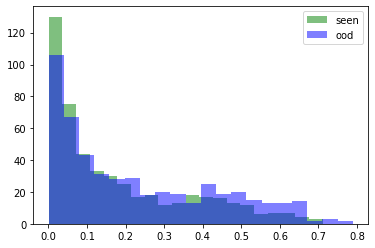

auroc of query image ood score
auroc: 0.5715159999999999


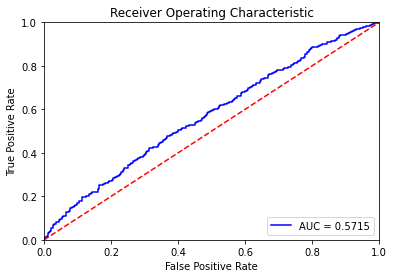

auroc of query image ideal ood score (distance to class center)
auroc: 0.674848


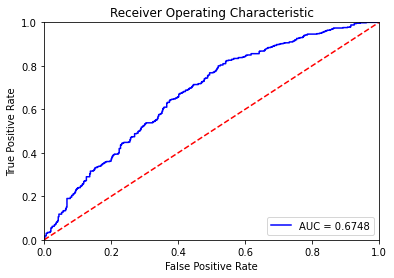

accuracy of query image from seen classes: 0.796


In [71]:
test_evaluation(model);

distribution of test ood score


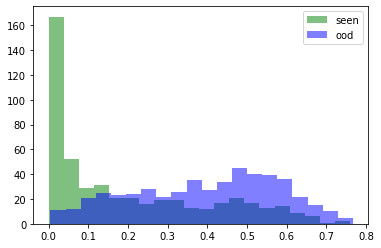

auroc of query image ood score
auroc: 0.7714239999999999


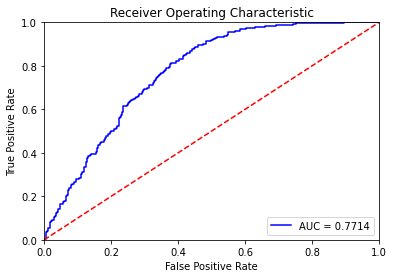

auroc of query image ideal ood score (pre-trained linear layer)
auroc: 0.795162


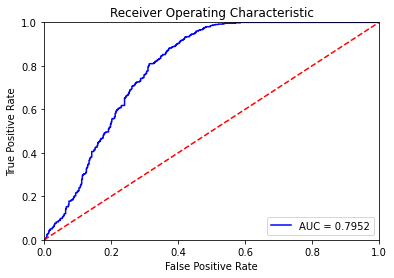

accuracy of query image from seen classes: 0.76


In [119]:
test_evaluation(model, k_shot=5, n_way=6, n_query_img=1000, seen_classes=list(range(6)), ood_classes=[999],
                    ood_dataset='gaussian', seed=2021, plot = True);

In [ ]:
if __name__ == "__main__":
    #wandb.finish()

    ### argparse ###
    parser = argparse.ArgumentParser()
    parser.add_argument("k_shot", type=int)
    parser.add_argument("n_way", type=int)
    parser.add_argument("n_query_image", type=int)
    parser.add_argument("ood_dataset")
    parser.add_argument("seed", type=int)
    parser.add_argument("exper")
    args = parser.parse_args()
    print('run {}-shot {}-way {} - {}'.format(args.k_shot, args.n_way, args.ood_dataset, args.exper))

    ### load datasets ###
    transform = T.Compose([T.ToTensor(),
                           T.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)), ])
    cifar10_dataset = CIFAR10(root="./data", train=True, transform=transform, download=False)
    torch.manual_seed(2021)
    cifar10_dataset_train, cifar10_dataset_val = torch.utils.data.random_split(cifar10_dataset, [40000, 10000])
    cifar10_dataset_test = CIFAR10(root="./data", train=False, transform=transform, download=False)
    svhn_dataset = SVHN(root="./data", split='train', transform=transform, download=False)
    tinyimagenet_dataset = torchvision.datasets.ImageFolder("./data/Imagenet_resize", transform=transform)
    lsun_dataset = torchvision.datasets.ImageFolder("./data/LSUN_resize", transform=transform)
    print("load datasets finished")


    ### load model ###
    model = Siamese_ResNet(BasicBlock, [2,2,2,2]).cuda()
    model.load_state_dict(torch.load("./stat_dict/baseline_pretrain_best.pth"))
    model.eval()
    print("load model finished")

    ### test evaluation and log to wandb ###
    wandb.login()
    wandb.init(mode="online",
               name='{}-shot {}-way {} - {}'.format(args.k_shot, args.n_way, args.ood_dataset, args.exper),
               project='Testing Evaluation - Baseline_Max_Softmax',
               tags=['{}-shot'.format(args.k_shot), '{}-way'.format(args.n_way), args.ood_dataset, args.exper],
               config={"k_shot": args.k_shot,
                       "n_way": args.n_way,
                       "n_query_image": args.n_query_image,
                       "seen_classes": list(range(args.n_way)),
                       "ood_classes": ([8,9] if args.ood_dataset == 'cifar10_test' else [999]),
                       "ood_dataset": args.ood_dataset,
                       "seed": args.seed
                       })

    pair_stat, query_img_stat, test_metrics = test_evaluation(
        model,
        wandb.config.k_shot,
        wandb.config.n_way,
        wandb.config.n_query_image,
        wandb.config.seen_classes,
        wandb.config.ood_classes,
        wandb.config.ood_dataset,
        wandb.config.seed,
        plot = False)

    wandb.log({
        "auroc_query_is_ood": test_metrics['auroc_query_is_ood'],
        "auroc_query_is_ood_ideal": test_metrics['auroc_query_is_ood_ideal'],
        "accuracy_query_seen": test_metrics['accuracy_query_seen']
    })

    wandb.finish()
    print("wandb logging finished")